<a href="https://colab.research.google.com/github/abeyp/sf-film-locations/blob/main/sf_film_locations_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis on SF Film Locations

Dataset obtained from: Google BigQuery Public Data


Using SQL and Pandas

Goal of exploratory data analysis is to develop an understanding of our data.

Outline: 
1. Getting the Dataset
2. Data Prep and Cleaning
3. Exploratory Analysis and Viz
4. Asking and Answering Questions
5. Inferences From the Analysis
6. Conclusion

## Dataset Description: 


Schema:
*   Title
*   release_year
*   locations
*   production_company
*   distributor
*   director
*   writer
*   actor_1
*   actor_2
*   actor_3

We can look at 
- the number of releases each year and see the trend of movie growth over the years and how the running total may look as well for sharp increases. 
- Look into top locations over all or for each year
Top production company's and distributors
- Looking ahead, we could combine another dataset to understand if any movies ranked highly overall or received awards.

In [2]:
#Authenticate colab

from google.colab import auth
auth.authenticate_user()
print('Authenticated')
%load_ext google.colab.data_table

Authenticated


In [3]:
# My Google Cloud Project

project_id = 'elated-bus-316920'

## Data Prep and Cleanning

Quick Notes: 
- GBQ Schema noted `release_year` as an `INTEGAR`...need to change to `DATETIME` if I want to work with years or decades overview

- Need to check for any null values as GBQ Schema notied `NULLABLE`
- lowercase all the text to help with seaching through categorical variables (Options here include creating my own function or using NLTK package)


In [4]:
# Import BigQuery through google-cloud-bigquery

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

#View number of rows in our dataset
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 3414 rows


In [5]:
#Creating Pandas DataFrame

df = client.query('''
  SELECT
    *
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`''').to_dataframe()

In [6]:
df.head()

,title,release_year,locations,fun_facts,production_company,distributor,director,writer,actor_1,actor_2,actor_3
0,A Jitney Elopement,1915,20th and Folsom Streets,None,The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
1,A Jitney Elopement,1915,Golden Gate Park,"During San Francisco's Gold Rush era, the Park...",The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
2,A Jitney Elopement,1915,Golden Gate Park,"During San Francisco's Gold Rush era, the Park...",The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
3,A Jitney Elopement,1915,20th and Folsom Streets,None,The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
4,Greed,1924,Cliff House (1090 Point Lobos Avenue),"In 1887, the Cliff House was severely damaged ...",Metro-Goldwyn-Mayer (MGM),Metro-Goldwyn-Mayer (MGM),Eric von Stroheim,Eric von Stroheim,Zasu Pitts,Gibson Gowland,Jean Hersholt


In [7]:
#TODO: Check for null values

# Exploratory Analysis

We have all categorical data. What can we do with categorical data?

In [8]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
# TODO: Summary Statistics we can pull for general overview of categorical data before going into the questions...

## How many distinct movies were shot each year in SF?

- year | total_titles

- year, count(distinct titles), group by the year, order by 2 desc

In [10]:
count_per_year = client.query('''
  SELECT
      release_year,
      COUNT(DISTINCT title) as total_titles
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  #WHERE release_year >= 2000 and release_year <= 2010
  GROUP BY 1
  ''').to_dataframe()
count_per_year

,release_year,total_titles
0,1915,1
1,1924,1
2,1927,1
3,1935,1
4,1936,2
...,...,...
71,2015,23
72,2016,16
73,2017,7
74,2018,5


How to check if numbers are correct?

Also noticed there are Movies and TV Shows in the film locations dataset. something to look into another time if I am able to find another dataset to join

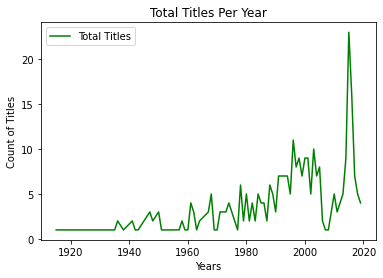

In [17]:
#Vizualization for Count of titles

#Plot data from columns
plt.plot(count_per_year['release_year'], count_per_year['total_titles'],color='g', label='Total Titles')
#plt.plot(ggb_count['release_year'], ggb_count['loc_count'], label='Golden Gate Bridge Locations Counts')

#Name Title and Labels
plt.xlabel('Years')
plt.ylabel('Count of Titles')
plt.title('Total Titles Per Year')

plt.legend()
plt.show()


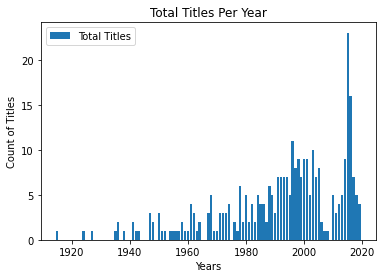

In [12]:
#Plot data from columns
plt.bar(count_per_year['release_year'], count_per_year['total_titles'], label='Total Titles')
#plt.plot(ggb_count['release_year'], ggb_count['loc_count'], label='Golden Gate Bridge Locations Counts')

#Name Title and Labels
plt.xlabel('Years')
plt.ylabel('Count of Titles')
plt.title('Total Titles Per Year')

plt.legend()
plt.show()


In [11]:
ggb_count = client.query('''
  SELECT
      release_year,
      COUNT(locations) as loc_count
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  WHERE locations like '%Golden Gate Bridge%'
  GROUP BY 1
  ''').to_dataframe()
ggb_count

,release_year,loc_count
0,1941,2
1,1947,2
2,1954,2
3,1955,2
4,1961,2
5,1968,2
6,1973,2
7,1974,2
8,1978,2
9,1979,2


Wanted to see how location plays against the total titles growth over the years. 

Strange to see GGB not follow a trend in growth of SF Film Locations. Possible that establishing shots of the bridge can be taken across the east side length of SF. For exmaple, around North Beach, Piers, etc. 

## What is the running total for titles filmed in SF?

In [13]:
running_title_total = client.query('''
WITH titles_by_year AS 
(
SELECT
      release_year,
      COUNT(DISTINCT title) as num_titles
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  GROUP BY 1
)
SELECT *,
    SUM(num_titles) OVER(ORDER BY release_year) as cumulative_titles
FROM titles_by_year
 ''').to_dataframe()
running_title_total

,release_year,num_titles,cumulative_titles
0,1915,1,1
1,1924,1,2
2,1927,1,3
3,1935,1,4
4,1936,2,6
...,...,...,...
71,2015,23,284
72,2016,16,300
73,2017,7,307
74,2018,5,312


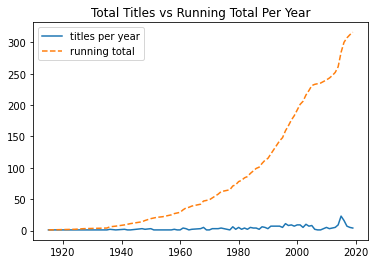

In [14]:
#Visualization of running total of titles

plt.plot(count_per_year['release_year'], count_per_year['total_titles'],label='titles per year')

plt.plot(count_per_year['release_year'], running_title_total['cumulative_titles'],linestyle='--', label = 'running total')

plt.title('Total Titles vs Running Total Per Year')

plt.legend()
plt.show()

We can see in the running total of titles, there is a sharp increase in titles as it curves up. A slight plataeu that sharply increases much more drastically in recent years. 

## What are the most popular SF film locations?


In [15]:
# How many distinct SF Locations are there? 
len(df['locations'].value_counts())

1400

In [16]:
#checking against SQL 

num_distinct_sf_locations = client.query('''
SELECT COUNT(DISTINCT locations) as num_of_locations
FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
WHERE locations IS NOT NULL''').to_dataframe()
num_distinct_sf_locations

,num_of_locations
0,1400


In [121]:
# Count of mentioned locations 
df['locations'].value_counts().to_frame()

,locations
Golden Gate Bridge,54
City Hall,45
"Fairmont Hotel (950 Mason Street, Nob Hill)",41
Treasure Island,28
Coit Tower,22
...,...
Castro District,1
Ada Court at O'Farrell St,1
738 Washington St,1
Sutter St at Taylor St,1


LIMITATIONS: slight differences in text. 
For example, Golden Gate Bridge being lowercase vs uppercase, having '-'

In NLTK Package: 
Tokeniation and stem each work in a list and rejoin on a space character. 

## Who are the top producers in our dataset?

Top production company's and distributors

curious which production company's are increasing their locations in SF over time in line chart. and a comparison against the others in a bar chart

In [161]:
#For Top Producers, we need the count of distinct titles each has produced.

titles_by_company = client.query('''
SELECT 
  production_company,
  COUNT(DISTINCT title) AS title_ct
FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
GROUP BY 1
ORDER BY 2 DESC
''').to_dataframe()
titles_by_company.head(10)

,production_company,title_ct
0,Paramount Pictures,20
1,Warner Bros. Pictures,16
2,Twentieth Century Fox Film Corporation,11
3,"Mission Street Productions, LLC",11
4,TVM Productions,11
5,Columbia Pictures Corporation,10
6,Universal Pictures,9
7,Touchstone Pictures,8
8,Metro-Goldwyn Mayer,6
9,Twentieth Century Fox Film Corp.,6


Needed to write a query that understood our top productions have the most distinct titles over our dataset's release years.

The below solution is wrong because every counting every row where a production company appears will indicate only the amount that a location was used. Companies can show up multiple times for 1 Movie or Show. 

In [28]:
top_prod = df['production_company'].value_counts(ascending=False).head(10).to_frame().reset_index()
top_prod

,index,production_company
0,"Mission Street Productions, LLC",250
1,Warner Bros. Pictures,198
2,Paramount Pictures,182
3,TVM Productions,168
4,Turner North Center Productions,116
5,"Unpronounceable Productions, LLC",84
6,TVM Productions Inc.,60
7,The Malpaso Company,60
8,Twentieth Century Fox Film Corporation,56
9,Perdido Productions,56


In [151]:
# Creating a dataframe where we have both release years and title counts for each top producer
# Focusing on Top 2 Producers: Paramount and Warner Bros

prod_titles_per_year = client.query('''
SELECT 
      release_year,
      production_company,
      COUNT(DISTINCT title) AS prod_count
FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
WHERE production_company = 'Paramount Pictures'
      OR production_company = 'Warner Bros. Pictures'
GROUP BY 1,2
    ''').to_dataframe()
prod_titles_per_year

,release_year,production_company,prod_count
0,1927,Warner Bros. Pictures,1
1,1941,Warner Bros. Pictures,1
2,1942,Warner Bros. Pictures,1
3,1947,Warner Bros. Pictures,2
4,1956,Paramount Pictures,1
5,1961,Warner Bros. Pictures,1
6,1962,Warner Bros. Pictures,1
7,1972,Paramount Pictures,1
8,1972,Warner Bros. Pictures,1
9,1974,Warner Bros. Pictures,1


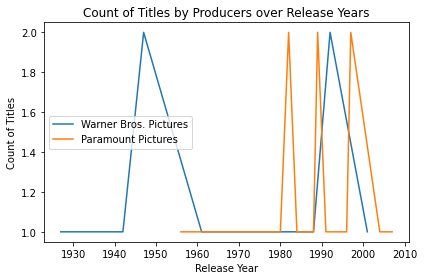

In [155]:
#Create dataframes for each production company
warner_prod = prod_titles_per_year[prod_titles_per_year['production_company'] == 'Warner Bros. Pictures']
paramount_prod = prod_titles_per_year[prod_titles_per_year['production_company'] == 'Paramount Pictures']

#create a line chart for each production company
plt.plot(warner_prod['release_year'],warner_prod['prod_count'],label='Warner Bros. Pictures')
plt.plot(paramount_prod['release_year'],paramount_prod['prod_count'],label='Paramount Pictures')

#Adjust tick marks on Release Years
#plt.xticks(range(1927,2021,5),rotation=75)

#Create Labels for Axis and Title
plt.xlabel('Release Year')
plt.ylabel('Count of Titles')
plt.title('Count of Titles by Producers over Release Years')

#Show Viz
plt.legend()
plt.tight_layout()
plt.show()

### Top Producers use of SF Locations

In [63]:
# Count of Top Productions over time

top_prod_ct = client.query('''
WITH prod_count_table AS(
  SELECT
        production_company,
        COUNT(production_company) as prod_count
  FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  GROUP BY 1
)  
SELECT
    production_company,
    prod_count
FROM prod_count_table
WHERE prod_count > 100
  ''').to_dataframe()
top_three_prod_ct

,production_company,prod_count
0,Warner Bros. Pictures,198
1,Paramount Pictures,182
2,"Mission Street Productions, LLC",250
3,Turner North Center Productions,116
4,TVM Productions,168


When creating visualizations for the Top 5 production companies by title count, I noticed: 
-  `Turner North Center Productions` 
-  `TVM Productions`
-  `Mission Street Productions, LLC`

did not show very well on the chart. 

Looking further in the cell bellow, they produced individual TV episodes for a season. Because of this edge case, we will not include it in the overall film history over the years. 

LIMITATION: I do not have a way of distingusihing between TV shows and Films with this dataset

In [112]:
df[df['production_company'] == 'Mission Street Productions, LLC'].head(5)

,title,release_year,locations,fun_facts,production_company,distributor,director,writer,actor_1,actor_2,actor_3
1882,Looking,2014,Jawbone at 99 Rhode Island St.,None,"Mission Street Productions, LLC",Home Box Office (HBO),Andrew Haigh,Michael Lannan,Jonathan Groff,Frankie J. Alvarez,Murray Bartlett
1883,Looking,2014,Willy's Barber Shop,None,"Mission Street Productions, LLC",Home Box Office (HBO),Andrew Haigh,Michael Lannan,Jonathan Groff,Frankie J. Alvarez,Murray Bartlett
1884,Looking,2014,Mr. S Leather,None,"Mission Street Productions, LLC",Home Box Office (HBO),Andrew Haigh,Michael Lannan,Jonathan Groff,Frankie J. Alvarez,Murray Bartlett
1885,Looking,2014,The Fairmont,None,"Mission Street Productions, LLC",Home Box Office (HBO),Andrew Haigh,Michael Lannan,Jonathan Groff,Frankie J. Alvarez,Murray Bartlett
1886,Looking,2014,Sutro Baths,None,"Mission Street Productions, LLC",Home Box Office (HBO),Andrew Haigh,Michael Lannan,Jonathan Groff,Frankie J. Alvarez,Murray Bartlett


In [79]:
# Count of Top Productions made over time

#Different query using HAVING
top_prod_ct_2 = client.query('''
  SELECT
        production_company,
        COUNT(1) as company_count
  FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  GROUP BY 1
  HAVING COUNT(1) > 100
  ORDER BY company_count DESC
    ''').to_dataframe()
top_prod_ct_2

,production_company,company_count
0,"Mission Street Productions, LLC",250
1,Warner Bros. Pictures,198
2,Paramount Pictures,182
3,TVM Productions,168
4,Turner North Center Productions,116


#### Creating Viz

In [156]:
# Creating a dataframe where we have both release years and title counts for each top producer

prod_years = client.query('''
  SELECT
        release_year,
        production_company,
        COUNT(1) as prod_count
  FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  GROUP BY 1,2
    ''').to_dataframe()

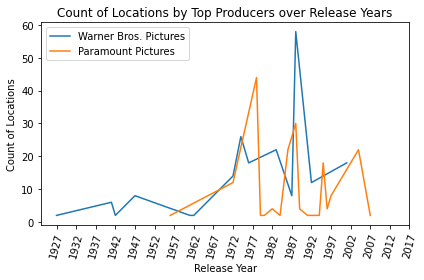

In [158]:
#Create dataframes for each production company
warner_prod = prod_years[prod_years['production_company'] == 'Warner Bros. Pictures']
paramount_prod = prod_years[prod_years['production_company'] == 'Paramount Pictures']

#create a line chart for each production company
plt.plot(warner_prod['release_year'],warner_prod['prod_count'],label='Warner Bros. Pictures')
plt.plot(paramount_prod['release_year'],paramount_prod['prod_count'],label='Paramount Pictures')

#Adjust tick marks on Release Years
plt.xticks(range(1927,2021,5),rotation=75)

#Create Labels for Axis and Title
plt.xlabel('Release Year')
plt.ylabel('Count of Locations')
plt.title('Count of Locations by Top Producers over Release Years')

#Show Viz
plt.legend()
plt.tight_layout()
plt.show()

## Who are the Top Distributors?

In [171]:
top_dist = client.query('''
SELECT 
  distributor,
  COUNT(DISTINCT title) AS title_ct
FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
GROUP BY 1
ORDER BY 2 DESC
''').to_dataframe()
top_dist.head(10)

,distributor,title_ct
0,Warner Bros. Pictures,29
1,Paramount Pictures,28
2,Columbia Pictures,19
3,Buena Vista Pictures,19
4,Universal Pictures,15
5,None,15
6,HBO,12
7,Twentieth Century Fox Film Corporation,11
8,HULU,11
9,United Artists,8


In [172]:
top_dist_years = client.query('''
SELECT 
      release_year,
      distributor,
      COUNT(DISTINCT title) AS prod_count
FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
WHERE distributor = 'Paramount Pictures'
      OR distributor = 'Warner Bros. Pictures'
GROUP BY 1,2
''').to_dataframe()
top_dist_years

,release_year,distributor,prod_count
0,1927,Warner Bros. Pictures,1
1,1941,Warner Bros. Pictures,1
2,1942,Warner Bros. Pictures,1
3,1947,Warner Bros. Pictures,2
4,1956,Paramount Pictures,1
5,1958,Paramount Pictures,1
6,1961,Paramount Pictures,1
7,1961,Warner Bros. Pictures,1
8,1962,Warner Bros. Pictures,1
9,1971,Paramount Pictures,1


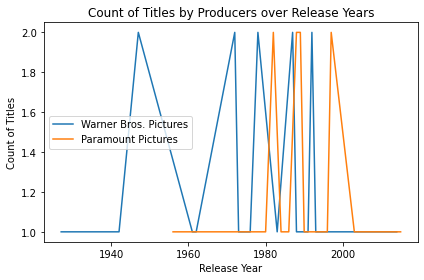

In [174]:
#Create dataframes for each production company
warner_prod = top_dist_years[top_dist_years['distributor'] == 'Warner Bros. Pictures']
paramount_prod = top_dist_years[top_dist_years['distributor'] == 'Paramount Pictures']

#create a line chart for each production company
plt.plot(warner_prod['release_year'],warner_prod['prod_count'],label='Warner Bros. Pictures')
plt.plot(paramount_prod['release_year'],paramount_prod['prod_count'],label='Paramount Pictures')

#Adjust tick marks on Release Years
#plt.xticks(range(1927,2021,5),rotation=75)

#Create Labels for Axis and Title
plt.xlabel('Release Year')
plt.ylabel('Count of Titles')
plt.title('Count of Titles by Producers over Release Years')

#Show Viz
plt.legend()
plt.tight_layout()
plt.show()

In [176]:
running_dist_years = client.query('''
WITH titles_by_year AS 
(
SELECT
      release_year,
      distributor,
      COUNT(DISTINCT title) as num_titles
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  WHERE distributor = 'Paramount Pictures'
    OR distributor = 'Warner Bros. Pictures'
  GROUP BY 1,2
)
SELECT *,
    SUM(num_titles) OVER(ORDER BY release_year) as cumulative_titles
FROM titles_by_year
 ''').to_dataframe()
running_dist_years

,release_year,distributor,num_titles,cumulative_titles
0,1927,Warner Bros. Pictures,1,1
1,1941,Warner Bros. Pictures,1,2
2,1942,Warner Bros. Pictures,1,3
3,1947,Warner Bros. Pictures,2,5
4,1956,Paramount Pictures,1,6
5,1958,Paramount Pictures,1,7
6,1961,Paramount Pictures,1,9
7,1961,Warner Bros. Pictures,1,9
8,1962,Warner Bros. Pictures,1,10
9,1971,Paramount Pictures,1,11


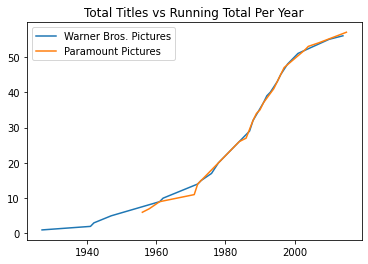

In [178]:
#Visualization of running total of titles

#Create dataframes for each production company
warner_dist = running_dist_years[running_dist_years['distributor'] == 'Warner Bros. Pictures']
paramount_dist = running_dist_years[running_dist_years['distributor'] == 'Paramount Pictures']

#create a line chart for each production company
plt.plot(warner_dist['release_year'],warner_dist['cumulative_titles'],label='Warner Bros. Pictures')
plt.plot(paramount_dist['release_year'],paramount_dist['cumulative_titles'],label='Paramount Pictures')

plt.title('Total Titles by Distributor vs Running Total Per Year')

plt.legend()
plt.show()

## Empty - Ideas

Maybe show more skills in seaching for text among directors and actors

# Inferences from Analysis

The questions I navigated towards was understanding film activity in SF over time. It seemed there was a lot of activity that grew starting in the 70s to 90s, with a plataeu during the 2000s. Assumptions towards a decrease in movies and instead more TV shows being filmed in SF. However, questions about movies vs TV shows are beyond this specific dataset. 

Dataset primed better for visualizing popular locations like in a geolocation. 

# Conclusion

- Production Companies and Distributors share similiar trends in the overall activity for SF Film locations. Throughout the 70s-90s, there are many titles filmed in SF with a plateau in recent years.

- If possible, would want to show the transition of movies to TV Shows being filmed in SF. 